<a href="https://colab.research.google.com/github/Sienna688/Machine-Learning/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Environment Setup:
This notebook is intended to be run on Google Colab. You may complete the tasks offline, but at your own risk.

## Add dataset shortcut from your Google Account
Because of the size of the datasets, we are providing the files from Google Drive.

To access the provided data, go to [this link](https://drive.google.com/drive/folders/1_5LoxbmWDKPKi91Z_HmQn4TFoTtXnxQM?usp=sharing) and click "COMP4211_dataset->Organise->Add shortcut" to save a shortcut in your Google Drive "My Drive" folder (or any specific path in your google drive)

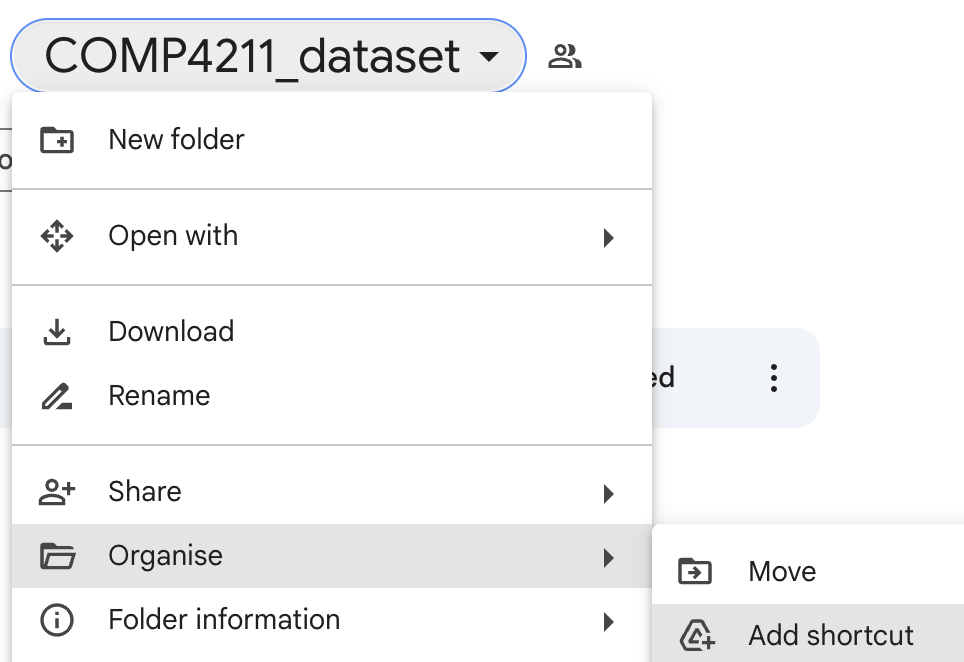

Mount the dataset by the following code (requires authorization):

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/COMP4211_dataset"
vgg_path = os.path.join(data_path, 'vgg19.npz')

pacs_zip = os.path.join(data_path, 'classify/pacs-dataset.zip')
wikiart_zip = os.path.join(data_path, 'wikiart.zip')
coco_zip = os.path.join(data_path, 'COCO.zip')

pacs_path = "classify"
wikiart_path = "wikiart"
coco_path = "COCO"


Mounted at /content/drive


To speed up the image loading, we unzip the training image datasets to the Google Colab VM rather than access it directly from Google Drive.

In [ ]:
!unzip "$wikiart_zip" > /dev/null 2>&1
!unzip "$coco_zip" > /dev/null 2>&1

(Tip: If you're only doing the second task, skip the above code to save a bit of time)

In [ ]:
# Put the PACS files in a subfolder
!mkdir -p "$pacs_path"
!unzip "$pacs_zip" -d "$pacs_path" > /dev/null 2>&1

## Preparation

This section contains imports and functions that will be used in the later tasks. Some of them are provided.

### Imports

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Important submodules and functions from Tensorflow (and Keras)
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Reshape, MaxPooling2D, Lambda, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import array_to_img

# Image handling and visualization
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display
from tqdm.notebook import tqdm
import cv2

# Other utility
import datetime
import psutil

# Module settings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This will hide all TensorFlow messages, except for errors.
tf.get_logger().setLevel('ERROR')  # This sets TensorFlow logger to only output error messages.

import random
from sklearn.preprocessing import OneHotEncoder


### Utility Functions

**Preprocessing and Deprocessing Images**: In style transfer, images often need to be adjusted before and after passing through the model. The `preprocess` function converts images from RGB (used in most image formats) to BGR (used by the model) and normalizes pixel values by subtracting a mean value. This step helps in aligning the image data with the format expected by the VGG network, which our style transfer model is based on. Conversely, the `deprocess` function reverses these adjustments, converting the image back from BGR to RGB and adding the mean pixel values, making the output image suitable for viewing.

**Loading Images**: The `get_image` function reads an image from the disk, converts it to the RGB format, and optionally resizes it. This function is crucial for preparing your dataset for training or evaluation. It ensures that all images fed into the model are consistent in size and format.

**Finding Images**: The `find_images` function takes a directory path and a file type, and finds (recursively) all files within the directory that matches the file type. This is used for obtaining the images in the WikiArt and COCO dataset, as the images are put in different folders.

In [ ]:
# Prepares an image for the model by converting RGB to BGR and subtracting the mean pixel values.
def preprocess(x):
    img = tf.reverse(x, axis=[-1])  # RGB to BGR
    img -= np.array([103.939, 116.779, 123.68])  # Subtract mean pixel value
    return img

# Converts the output of the model back to a viewable image by adding mean pixel values and converting BGR to RGB.
def deprocess(x):
    img = x + np.array([103.939, 116.779, 123.68])  # Add mean pixel value
    img = tf.reverse(img, axis=[-1])  # BGR to RGB
    img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure pixel value range is valid
    return img

# Loads an image from disk, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(256,256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    image = image.astype(np.float32)  # Convert to float32 for model compatibility
    return image

# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path, file_type):
    image_paths = []

    for root, _, files in os.walk(dir_path):
        for file in files:
            if f'.{file_type}' in file:
                image_paths.append(os.path.join(root, file))

    return image_paths


### Datasets

This programming assignment requires 2 types of dataset, both used for loading images on-demand:

- `ImageDataset`, a dataset class that finds and collects image files within a given directory, and loads them for training. A single sample should only include the image bitmap (preprocessed using the above functions).
- `ClassificationDataset`, a dataset class that references a given `.tsv` file for file names and labels, and loads the images from the given directory along with the class label. A single sample should include the processed image bitmap, along with its class label in one-hot encoding.

In [ ]:
class ImageDataset:
    def __init__(self, dir_path, batch_size=8, file_type="jpg", random_state = 4211):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.file_type = file_type
        self.random_state = random_state
        self.image_paths = find_images(dir_path, file_type)
        self.ds_pointer = 0
        self.reset_pointer(self.random_state)


    def reset_pointer(self, seed=None):
        self.ds_pointer = 0
        if seed is not None:
          random.seed(seed)
        else:
          random.seed(self.random_state)
        random.shuffle(self.image_paths)


    def get_batch(self):
        batch = []
        while len(batch) < self.batch_size:
          img_path = self.image_paths[self.ds_pointer]
          img = get_image(img_path)
          preprocessed_img = preprocess(img)
          batch.append(preprocessed_img)
          self.ds_pointer += 1
          if self.ds_pointer >= len(self.image_paths):
            self.reset_pointer()
        return np.array(batch)


    def __len__(self):
        return len(self.image_paths)


In [ ]:
# COCO dataset
coco_dataset = ImageDataset(coco_path)
len(coco_dataset)

3557

In [ ]:
# WikiArt dataset
wikiart_dataset = ImageDataset(wikiart_path)
len(wikiart_dataset)

7492

In [ ]:
# Here's a preview of what the TSV would look like (top 10 rows):
!cat "$pacs_path/train-data.tsv" | head -n 10

cat: classify/train-data.tsv: No such file or directory


In [ ]:
# [C2]
class ClassificationDataset:
    def __init__(self, tsv_path, dir_path, batch_size=8, random_state = 4211):

        self.dir_path = dir_path
        self.tsv_path = tsv_path
        self.data_table = self._process_tsv(tsv_path, dir_path)
        self.batch_size = batch_size
        self.random_state = random_state
        self.ds_pointer = 0
        self.class_name = []
        self._process_tsv(tsv_path, dir_path)

    # Tip: It is recommended to use this method to process the tsv data into a data table, since this will be used in both __init__() and add_data().
    def _process_tsv(self, tsv_path, dir_path):
        data = pd.read_csv(tsv_path, sep='\t', header=None, names=['filename', 'style', 'class_label'])
        encoder = OneHotEncoder(sparse=False)
        one_hot_labels = encoder.fit_transform(data[['class_label']])
        data['one_hot_label'] = one_hot_labels.tolist()

        categories = encoder.categories_[0]
        self.class_name = [category for category in categories]

        data['dir_path'] = dir_path
        return data


    def add_data(self, tsv_path, dir_path):
        new_data = self._process_tsv(tsv_path, dir_path)
        self.data_table = self.data_table.append(new_data, ignore_index=True)


    def reset_pointer(self, seed=None):
        if seed is not None:
          random.seed(seed)
        else:
          random.seed(self.random_state)
        self.ds_pointer = 0
        self.data_table = self.data_table.sample(frac=1, random_state=self.random_state)


    def get_batch(self):
        batch_images = []
        batch_labels = []

        while len(batch_images) < self.batch_size:
          # Load and preprocess image
          img_path = os.path.join(self.data_table.iloc[self.ds_pointer]['dir_path'], self.data_table.iloc[self.ds_pointer]['filename'])
          img = get_image(img_path)
          preprocessed_img = preprocess(img)
          # Add image and label to batch
          batch_images.append(preprocessed_img)
          batch_labels.append(self.data_table.iloc[self.ds_pointer]['one_hot_label'])

          # Increment pointer
          self.ds_pointer += 1
          # not enough samples left to be loaded in the batch
          if self.ds_pointer >= len(self.data_table):
            self.reset_pointer()
        # shuffle the data
        self.data_table = self.data_table.sample(frac=1, random_state=self.random_state)
        return np.array(batch_images), np.array(batch_labels)


    def __len__(self):
        return len(self.data_table)



In [ ]:
pacs_train = ClassificationDataset('/content/classify/train-data.tsv','/content/classify/train-files')
len(pacs_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1641

In [ ]:
pacs_test = ClassificationDataset('/content/classify/test-data.tsv','/content/classify/test-files')
len(pacs_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2723

## Part 1: Style Transfer


### Model Components

In [ ]:
class AdaIN(Layer):
    """
    Adaptive Instance Normalization (AdaIN) layer with controllable style transfer intensity.
    This layer adjusts the mean and variance of the content features to match those of the style features,
    then blends the result with the original content features based on a specified alpha value.
    """
    def __init__(self, epsilon=1e-5, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.epsilon = epsilon  # Small constant to avoid division by zero.

    def call(self, inputs):
        content, style, alpha = inputs

        # Compute mean and variance for content and style features.
        meanC, varC = tf.nn.moments(content, [1, 2], keepdims=True)
        meanS, varS = tf.nn.moments(style, [1, 2], keepdims=True)

        # Standard deviation is the square root of variance, adjusted with epsilon for numerical stability.
        sigmaC = tf.sqrt(varC + self.epsilon)
        sigmaS = tf.sqrt(varS + self.epsilon)

        # Perform AdaIN by normalizing content features and scaling them by style's standard deviation and mean.
        normalized_content = (content - meanC) / sigmaC
        stylized_content = normalized_content * sigmaS + meanS

        # Blend stylized content with original content based on alpha.
        blended_content = alpha * stylized_content + (1 - alpha) * content
        return blended_content

In [ ]:
def build_vgg19_enc(input_shape, weights_path):
    weights = np.load(weights_path)

    # [C3] Create vgg19 structure

    model = models.Sequential()

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape, name='conv1_1'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv1_2'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='pool1'))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='pool2'))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_4'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='pool3'))

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1'))


    # [C4] Load in weights and freeze the model

    i = 0
    for layer in model.layers:
        if layer.name.startswith('conv'):
            kernel = weights['arr_%d' % i].astype(np.float32)
            bias = weights['arr_%d' % (i + 1)].astype(np.float32)
            kernel = kernel.transpose([2, 3, 1, 0])
            layer.set_weights([kernel, bias])
            i += 2
    model.trainable = False
    return model


def build_vgg19_relus(vgg19):
    relus = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
    features = [vgg19.get_layer(relu).output for relu in relus]
    vgg19_relus = Model(inputs=vgg19.input, outputs=features)
    vgg19_relus.trainable = False
    return vgg19_relus

# [C5]
def build_decoder(input_shape):
    model = models.Sequential()

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(3, (3, 3), padding='same'))

    model.summary()

    return model


def build_model(encoder, decoder, input_shape):
    content = Input(shape=input_shape, name='content')
    style = Input(shape=input_shape, name = 'style')
    alpha = Input(shape=(1,), name='alpha')

    enc_content = encoder(content)
    enc_style = encoder(style)

    adain = AdaIN()([enc_content, enc_style, alpha])

    out = decoder(adain)

    return Model(inputs=[content, style, alpha], outputs=[out, adain])


In [ ]:
def get_loss(encoder, vgg19_relus, epsilon=1e-5, style_weight=1.0):

    def loss(y_true, y_pred):
        out, adain = y_pred[0], y_pred[1]

        # Encode output and compute content_loss
        out = deprocess(out)
        out = preprocess(out)
        enc_out = encoder(out)
        content_loss = tf.reduce_sum(tf.reduce_mean(tf.square(enc_out - adain), axis=[1, 2]))

        # Compute style loss from vgg relus
        style = y_true[1]
        style_featues = vgg19_relus(style)
        gen_features = vgg19_relus(out)
        style_layer_loss = []
        for enc_style_feat, enc_gen_feat in zip(style_featues, gen_features):
            meanS, varS = tf.nn.moments(enc_style_feat, [1, 2])
            meanG, varG = tf.nn.moments(enc_gen_feat,   [1, 2])

            sigmaS = tf.sqrt(varS + epsilon)
            sigmaG = tf.sqrt(varG + epsilon)

            l2_mean  = tf.reduce_sum(tf.square(meanG - meanS))
            l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS))

            style_layer_loss.append(l2_mean + l2_sigma)

        style_loss = tf.reduce_sum(style_layer_loss)

        # Compute the total loss
        weighted_style_loss = style_weight * style_loss
        total_loss = content_loss + weighted_style_loss
        return total_loss, content_loss, weighted_style_loss

    return loss

### Training Routine

In [ ]:
def part1_train(model, content_ds, style_ds, loss_fn, n_epochs = 10, save_interval = 10, save_path=None, load_path=None):
    # Initialize the Optimizer

    optimizer = keras.optimizers.Adam(learning_rate=1e-4, weight_decay=5e-5)

    # Calculate the number of batches per epoch
    n_batches = np.math.ceil(len(content_ds)/content_ds.batch_size)

    # Initialize other things
    process = psutil.Process(os.getpid())
    alpha = 1.0

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators

        content_ds.reset_pointer()
        style_ds.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"total": 0.0, "content": 0.0, "style": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches

            content_sample = content_ds.get_batch()
            style_sample = style_ds.get_batch()

            # Execute Batch Training
            # Tip: Use tf.GradientTape() when computing the loss, to obtain the gradient.

            with tf.GradientTape() as tape:
                # Pass the content and style images (along with alpha) to obtain the model output
                output, adain = model([content_sample, style_sample, alpha])
                # Compute the loss
                total_loss, content_loss, style_loss = loss_fn([content_sample, style_sample],[output, adain])
            # Obtain the gradients of the total loss with respect to the model's trainable variables
            gradients = tape.gradient(total_loss, model.trainable_variables)
            # Apply the gradients using the optimizer
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update Loss Metrics

            losses["total"] = (losses["total"] * i + total_loss) / (i+1)
            losses["content"] = (losses["content"] * i + content_loss) / (i+1)
            losses["style"] = (losses["style"] * i + style_loss) / (i+1)

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform a save on the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)

### Model setup

In [ ]:
def part1_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 8 # Recommended according to the Google Colab T4 GPU

    content_ds = ImageDataset(coco_path, batch_size=BATCH_SIZE)
    style_ds = ImageDataset(wikiart_path, batch_size=BATCH_SIZE)

    return content_ds, style_ds

def part1_setup():
    #####
    # MODIFY SETTINGS HERE
    #####
    STYLE_WEIGHT = 2.0
    EPSILON = 1e-5

    INPUT_SHAPE = (None, None, 3) # We accept any image size

    # Build model
    vgg19 = build_vgg19_enc(INPUT_SHAPE, vgg_path)  # encoder
    decoder = build_decoder(vgg19.output.shape[1:])  # input shape == encoder output shape
    model = build_model(vgg19, decoder, INPUT_SHAPE)

    # Get loss
    vgg19_relus = build_vgg19_relus(vgg19)
    loss = get_loss(vgg19, vgg19_relus, epsilon=EPSILON, style_weight=STYLE_WEIGHT)

    return model, loss

In [ ]:
content_ds, style_ds = part1_prepare_datasets()

In [ ]:
model, loss = part1_setup()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 256)   1179904   
                                                                 
 up_sampling2d (UpSampling2  (None, None, None, 256)   0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 256)   590080    
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 256)   590080    
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 256)   590080    
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 128)   295040    
                                                      

We can now start the training:

In [ ]:
#####
# We recommend you to save on your mounted Google Drive folder,
# otherwise it may get lost after the Colab session terminated
#####
PART1_SAVE_PATH = "/content/drive/MyDrive/saved.h5" # Change to your own path.

part1_train(model, content_ds, style_ds, loss, n_epochs=5, save_path=PART1_SAVE_PATH)

<ipython-input-23-b31479871602>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(content_ds)/content_ds.batch_size) # [Your code here]


  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

In [ ]:
model.save(PART1_SAVE_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# To continue to train the saved weights, do this:
PART1_LOAD_PATH = '/content/drive/MyDrive/saved.h5' # Change to your own path

part1_train(model, content_ds, style_ds, loss, n_epochs=5, save_path=PART1_SAVE_PATH, load_path=PART1_LOAD_PATH)

<ipython-input-23-b31479871602>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(content_ds)/content_ds.batch_size) # [Your code here]


  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

In [ ]:
model.save(PART1_SAVE_PATH)

In [ ]:
# To continue to train the saved weights, do this:
PART1_LOAD_PATH = '/content/drive/MyDrive/saved.h5' # Change to your own path

part1_train(model, content_ds, style_ds, loss, n_epochs=3, save_path=PART1_SAVE_PATH, load_path=PART1_LOAD_PATH)

<ipython-input-23-b31479871602>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(content_ds)/content_ds.batch_size) # [Your code here]


  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

In [ ]:
model.save(PART1_SAVE_PATH)

In [ ]:
# To continue to train the saved weights, do this:
PART1_LOAD_PATH = '/content/drive/MyDrive/saved.h5' # Change to your own path

part1_train(model, content_ds, style_ds, loss, n_epochs=2, save_path=PART1_SAVE_PATH, load_path=PART1_LOAD_PATH)

<ipython-input-23-b31479871602>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(content_ds)/content_ds.batch_size) # [Your code here]


  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

In [ ]:
model.save(PART1_SAVE_PATH)

Note: Due to the limited computing time available in Colab, it may be a good idea to divide the training into different sessions, by saving and loading the model weights in your Google Drive.  

Do not save the weights outside the drive or they will be deleted after the session ends!

### Inference

In [ ]:
# [C7]
def part1_inference(model_path, content_path, style_path, alpha):
  model = load_model(model_path, custom_objects={'AdaIN': AdaIN})

  # Get content image

  content_image = get_image(content_path)
  content_image = preprocess(content_image)
  content_image = np.expand_dims(content_image, axis=0)

  # Get style image

  style_image = get_image(style_path)
  style_image = preprocess(style_image)
  style_image = np.expand_dims(style_image, axis=0)

  # Set alpha Value

  alpha_tensor = tf.constant([alpha], dtype=tf.float32)

  # Do inference

  output = model.predict([content_image, style_image, alpha_tensor])

  # Convert output array to image

  output_image = deprocess(output[0])
  output_image = tf.squeeze(output_image)
  img = array_to_img(output_image)

  # img = img.resize((cv2.imread(content_path).shape[1], cv2.imread(content_path).shape[0]))
  # Display the image in the Notebook
  # display(img)
  return img

1/1 [==============================] - 2s 2s/step


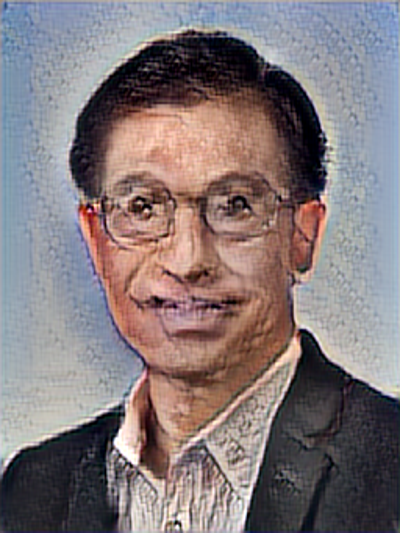

In [ ]:
#####
# MODIFY SETTINGS HERE
#####
PART1_SAVE_PATH = "/content/drive/MyDrive/saved.h5"
ALPHA = 0.75
MODEL_PATH = PART1_SAVE_PATH
# Here below is a sample, please change to your own path
CONTENT_PATH = os.path.join(data_path, 'HKUST/dyyeung.jpg')
# Here below is a sample, please change to your own path
STYLE_PATH = os.path.join('wikiart/Analytical_Cubism/juan-gris_portrait-of-maurice-raynal-1911.jpg')

display(part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA))

1/1 [==============================] - 2s 2s/step


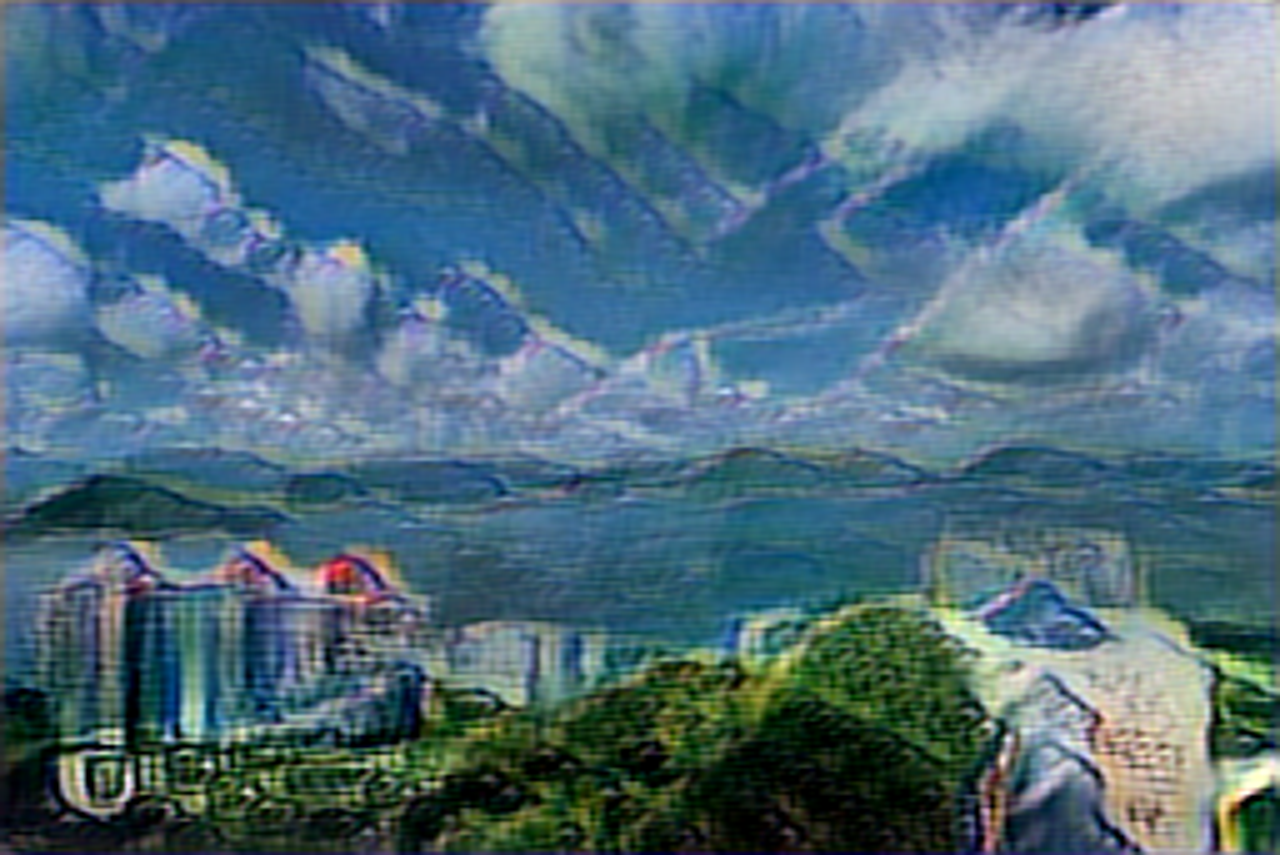

In [ ]:
# Another sample, please change and test on your own
ALPHA=0.75
CONTENT_PATH = os.path.join(data_path, 'HKUST/7.jpeg')
MODEL_PATH = PART1_SAVE_PATH
STYLE_PATH = os.path.join(data_path, 'Extra_styles/the-starry-night.jpg')
display(part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA))

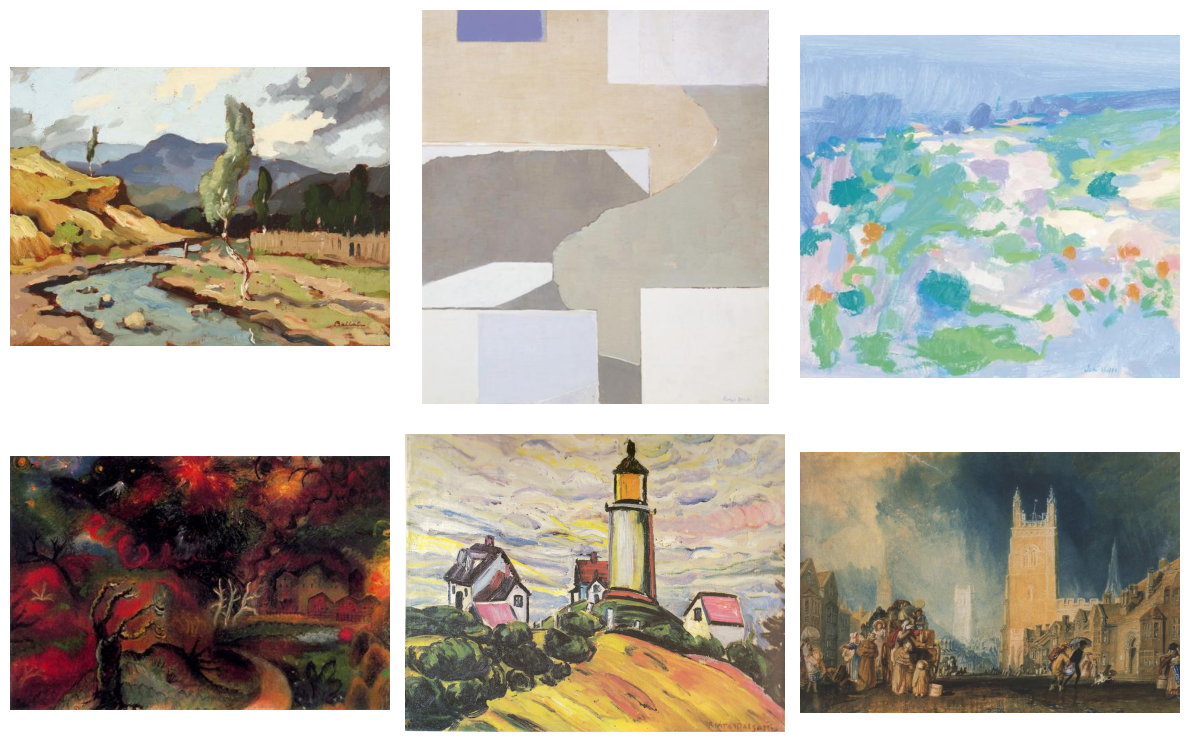

In [ ]:
# Define the six STYLE_PATH values
style_paths = [
    '/content/wikiart/Impressionism/adam-baltatu_after-rain.jpg',
    '/content/wikiart/Abstract_Expressionism/kenzo-okada_white-and-brown-1972.jpg',
    '/content/wikiart/Contemporary_Realism/john-miller_algarve-landscape.jpg',
    '/content/wikiart/Expressionism/albert-bloch_night-v-1917.jpg',
    '/content/wikiart/Expressionism/anita-malfatti_o-farol-1915.jpg',
    '/content/wikiart/Romanticism/william-turner_stamford.jpg'
]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    img = mpimg.imread(style_paths[i])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 2s 2s/step


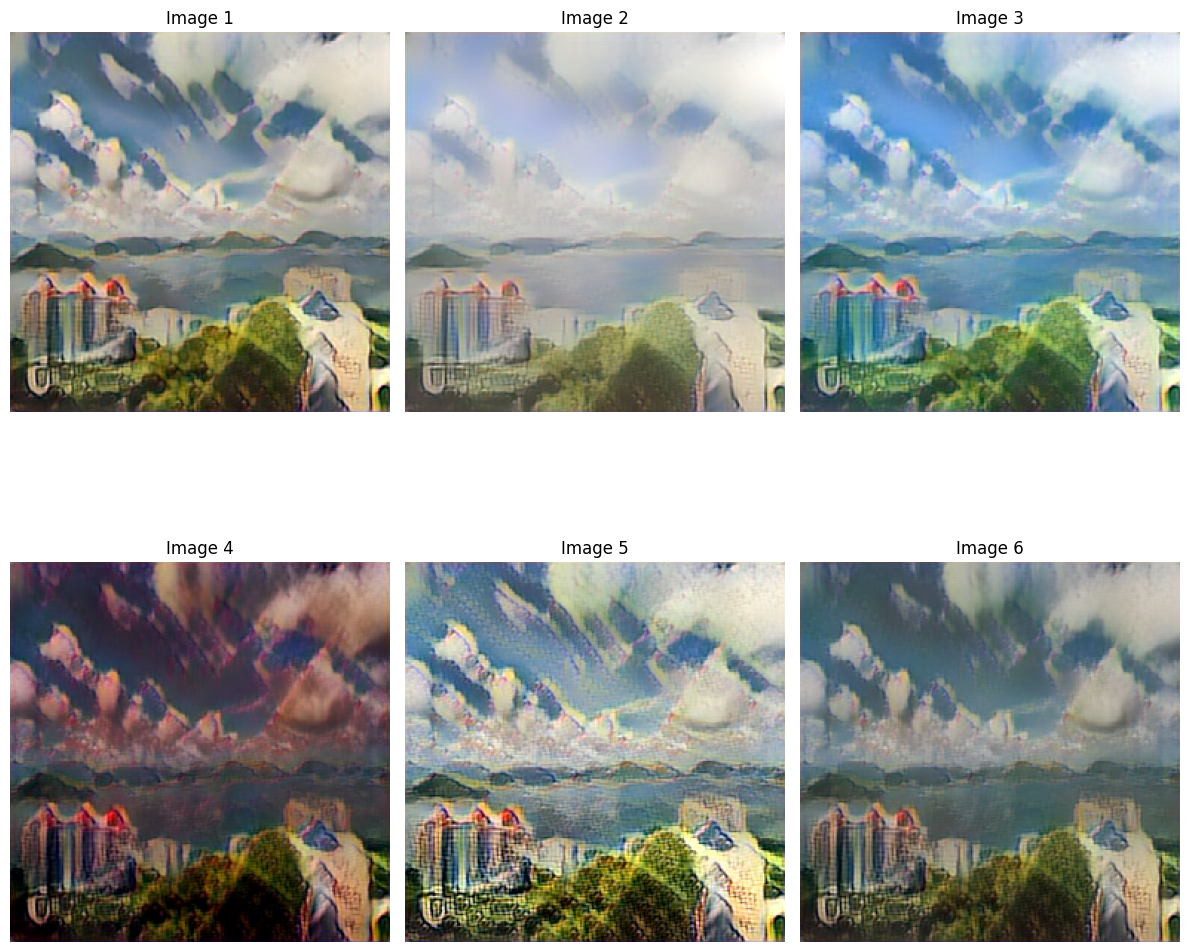

In [ ]:
ALPHA=0.75
CONTENT_PATH = os.path.join(data_path, 'HKUST/7.jpeg')
MODEL_PATH = PART1_SAVE_PATH

# Create a figure with a 3x2 grid layout
fig, axes = plt.subplots(2, 3, figsize=(12, 12))

for i in range(6):
    # Calculate the subplot indices
    row = i // 3
    col = i % 3
    # Run the inference function
    img = part1_inference(MODEL_PATH, CONTENT_PATH, os.path.join(style_paths[i]), ALPHA)
    # Get the current axis
    ax = axes[row, col]
    # Remove the axis labels
    ax.axis('off')
    # Set the title for the subplot
    ax.set_title(f'Image {i+1}')
    # Display the image on the current subplot
    ax.imshow(img)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

## Part 2: Classification Task

The second part of this assignment is a Classification Task, but with an unideal training dataset.

This task uses the PACS dataset (an image dataset with images of different categories and in different styles), but modified to have an abnormal distribution between styles and categories.

### Analyzing the dataset

Before we start the classification task, let's load and obtain some basic info about our training dataset.

In [ ]:
def part2_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    TEST_DS_PATH = os.path.join(pacs_path, "test-files/")
    TEST_TSV_PATH = os.path.join(pacs_path, "test-data.tsv")

    train_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    test_ds = ClassificationDataset(TEST_TSV_PATH, TEST_DS_PATH, batch_size = BATCH_SIZE)

    return train_ds, test_ds

train_ds, test_ds = part2_prepare_datasets()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

Find out the distribution of images in diferent styles and categories:

In [ ]:
train_ds.data_table.head(5)

filename   style class_label                        one_hot_label  \
0  pic_2524.jpg  sketch         dog  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
1   pic_888.jpg  sketch         dog  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
2  pic_1279.jpg  sketch         dog  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
3  pic_2694.jpg  sketch         dog  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
4    pic_79.jpg  sketch         dog  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

                dir_path  
0  classify/train-files/  
1  classify/train-files/  
2  classify/train-files/  
3  classify/train-files/  
4  classify/train-files/

In [ ]:
train_ds.class_name

['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

In [ ]:
# [C8]
def part2_tally_samples(dataset):

    tally = dataset.data_table.groupby(['style', 'class_label']).size()
    return tally

part2_tally_samples(train_ds)

style         class_label
art_painting  dog             13
              elephant        13
              giraffe        231
              guitar          10
              horse          180
              house           11
              person          11
cartoon       dog             10
              elephant        13
              giraffe         12
              guitar         121
              horse           11
              house           12
              person          12
photo         dog             10
              elephant        13
              giraffe         12
              guitar          10
              horse           11
              house          215
              person         211
sketch        dog            229
              elephant       217
              giraffe         10
              guitar           9
              horse            8
              house           13
              person          13
dtype: int64

Text(0, 0.5, 'Count')

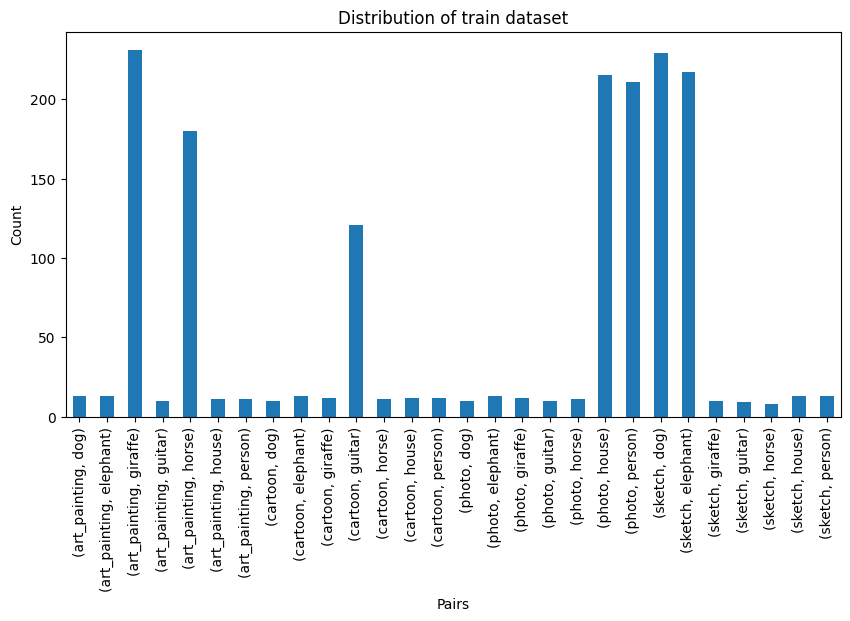

In [ ]:
# Plot the distribution of train
plt.figure(figsize=(10, 5))
part2_tally_samples(train_ds).plot(kind='bar')
plt.title('Distribution of train dataset')
plt.xlabel('Pairs')
plt.ylabel('Count')

In [ ]:
test_ds.class_name

['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

Compare this to the test dataset:

In [ ]:
part2_tally_samples(test_ds)

style         class_label
art_painting  dog            119
              elephant        89
              giraffe        110
              guitar          82
              horse           90
              house          110
              person          96
cartoon       dog             95
              elephant        83
              giraffe        109
              guitar          82
              horse           81
              house          101
              person          95
photo         dog             81
              elephant        83
              giraffe        102
              guitar          81
              horse          103
              house           95
              person         110
sketch        dog            112
              elephant       115
              giraffe        104
              guitar          95
              horse          108
              house           80
              person         112
dtype: int64

Text(0, 0.5, 'Count')

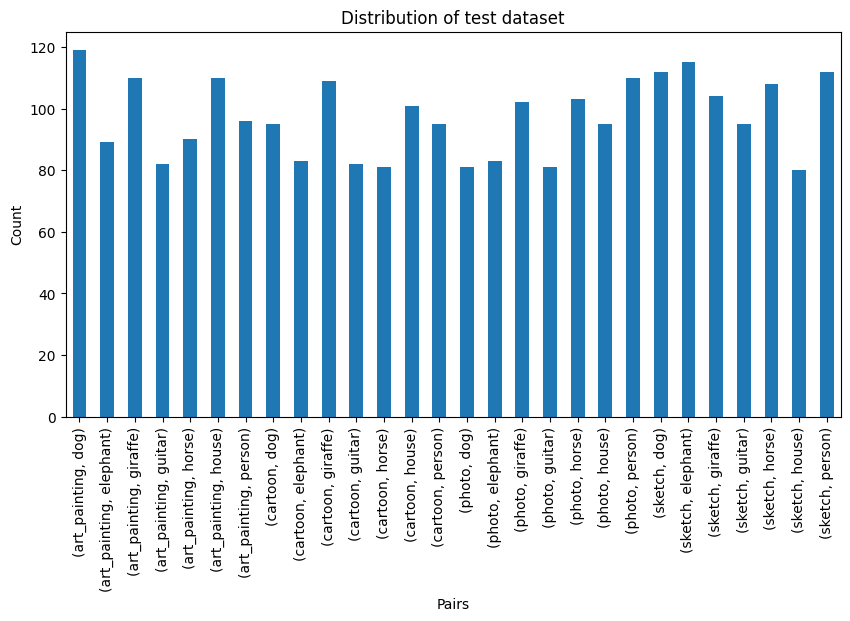

In [ ]:
# Plot the distribution of test
plt.figure(figsize=(10, 5))
part2_tally_samples(test_ds).plot(kind='bar')
plt.title('Distribution of test dataset')
plt.xlabel('Pairs')
plt.ylabel('Count')

### Main Implementation

The architecture of the classification model is also a VGG19 model, adapted for multiclass classification.

In [ ]:
# [C9]
def build_vgg19_classifier(input_shape, num_class):
    # Create vgg19 structure


    model = models.Sequential()

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape, name='conv1_1'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv1_2'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='pool1'))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='pool2'))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_4'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='pool3'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1'))

    model.add(layers.GlobalAveragePooling2D(name='global_pool'))
    model.add(layers.Dense(1024, activation='relu', name ='dense1'))
    model.add(layers.Dense(1024, activation='relu', name ='dense2'))
    model.add(layers.Dense(512, activation='relu', name ='dense3'))
    model.add(layers.Dense(num_class, activation='softmax', name ='dense4'))

    model.summary()

    return model

def build_model2(classifier, input_shape):
    img = Input(shape=input_shape, name='img')
    label = classifier(img)

    return Model(inputs=img, outputs= label)

In [ ]:
# [This part is not graded but is required for successful completion of other tasks]
def get_loss2(classifier):
    def loss(y_true, y_pred):
        cce = tf.keras.losses.CategoricalCrossentropy()
        img_loss = cce(y_true, y_pred)
        return img_loss
    return loss

In [ ]:
# [This part is not graded but is required for successful completion of other tasks]
def part2_setup(LOAD_PATH = None):
    INPUT_SHAPE = (None, None, 3)

    # Build model
    vgg19 = build_vgg19_classifier(INPUT_SHAPE, len(train_ds.class_name))
    model = build_model2(vgg19, INPUT_SHAPE)

    # Get Loss
    loss_fn = get_loss2(vgg19)

    if LOAD_PATH:
        model.load_weights(LOAD_PATH)

    return model, loss_fn

### Training the model with the given dataset

In [ ]:
# [C10]
def part2_train(model, dataset, loss_fn, n_epochs = 100, save_interval = 10, save_path=None, load_path=None):
    # Initialize the Optimizer
    optimizer = keras.optimizers.Adam(learning_rate=1e-4, weight_decay=5e-5)

    # Calculate the number of batches per epoch
    n_batches = np.math.ceil(len(dataset)/dataset.batch_size)

    # Initialize other things
    process = psutil.Process(os.getpid())

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators

        dataset.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"cross-entropy": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches

            img_sample, label_sample = dataset.get_batch()

            # Execute Batch Training

            with tf.GradientTape() as tape:
                # Pass the content and style images (along with alpha) to obtain the model output
                output= model(img_sample)
                # Compute the loss
                loss = loss_fn(label_sample,output)
            # Obtain the gradients of the total loss with respect to the model's trainable variables
            gradients = tape.gradient(loss, model.trainable_variables)
            # Apply the gradients using the optimizer
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update Loss Metrics

            losses["cross-entropy"] = (losses["cross-entropy"] * i + loss) / (i+1)

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform save the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)


In [ ]:
model2, loss2 = part2_setup()
# model2, loss2 = part2_setup()

In [ ]:
# Train the model
PART2_SAVE_PATH = "/content/drive/MyDrive/classify.h5" # [Change to your own path]

In [ ]:
# Train the model
PART2_SAVE_PATH = "/content/drive/MyDrive/classify.h5" # [Change to your own path]

# [Call your train function here]
part2_train(model2, train_ds, loss2, n_epochs=100, save_path=PART2_SAVE_PATH)

<ipython-input-10-f7dd8cf797b9>:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(dataset)/dataset.batch_size) # [Your code here]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
# model2.save(PART2_SAVE_PATH)
part2_train(model2, train_ds, loss2, n_epochs=40, save_path=PART2_SAVE_PATH, load_path = PART2_SAVE_PATH)

<ipython-input-12-f7dd8cf797b9>:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(dataset)/dataset.batch_size) # [Your code here]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

### Testing

We can now test our first classifier model with the test dataset (maybe train dataset too, to make sure the training went properly).

Calculate the accuracy of the model, as well as the confusion matrix to for a clearer idea on the model's performance:

In [ ]:
# [C11]
from sklearn.metrics import accuracy_score, confusion_matrix

def part2_evaluate(model, dataset):

    # Initialize variables for accumulating predictions and ground truth labels
    all_predictions = []
    all_labels = []

    n_batches = np.math.ceil(len(dataset)/dataset.batch_size)

    # Iterate over all batches in the dataset
    for i in range(n_batches):
        batch_images, batch_labels = dataset.get_batch()
        batch_predictions = model.predict(batch_images)

        # Convert one-hot encoded labels to discrete labels
        batch_labels = np.argmax(batch_labels, axis=1)
        batch_predictions = np.argmax(batch_predictions, axis=1)

        all_predictions.extend(batch_predictions)
        all_labels.extend(batch_labels)

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_predictions)

    # Calculate confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_predictions)

    return accuracy, confusion_mat

In [ ]:
# Report the accuracy and confusion matrix of the model trained in the previous section
# when tested against the training and test datasets respectively

acc_train, matrix_train = part2_evaluate(model2, train_ds)

<ipython-input-23-d68ace3e562c>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(dataset)/dataset.batch_size)


2/2 [==============================] - 0s 115ms/step


In [ ]:
print(acc_train)
print(matrix_train)

0.9831730769230769
[[309  22   0   0   0   0   0]
 [  0 262   0   0   0   0   0]
 [  1   0 245   0   0   0   0]
 [  0   0   0 144   0   0   0]
 [  0   0   1   0 182   0   0]
 [  0   0   0   0   0 253   0]
 [  3   0   0   0   0   1 241]]


In [ ]:
acc_test, matrix_test = part2_evaluate(model2, test_ds)

<ipython-input-23-d68ace3e562c>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(dataset)/dataset.batch_size)


2/2 [==============================] - 0s 118ms/step


In [ ]:
print(acc_test)
print(matrix_test)

0.4629360465116279
[[126  55  86  53 137  29   6]
 [ 20 159  46   7  53  19  23]
 [ 65  30 198  17  30  45  15]
 [ 38   7  35 200  38  23  21]
 [110  30  18  34 145  37   3]
 [  3  15  64  12  19 261   1]
 [ 41  24  52  33  49  35 185]]


In [ ]:
# Showcase some of the mislabeled sample images
def mislable(model,dataset, counter=1):
    n_batches = np.math.ceil(len(dataset)/dataset.batch_size)
    mislabeled_counter = 0
    for i in range(n_batches):
      batch_images, batch_labels = dataset.get_batch()
      batch_predictions = model.predict(batch_images)
      batch_labels = np.argmax(batch_labels, axis=1)
      batch_predictions = np.argmax(batch_predictions, axis=1)

      mislabeled = np.where(batch_predictions != batch_labels)[0]
      if(len(mislabeled) > 0):
        for j in mislabeled:
          true_label = dataset.class_name[batch_labels[j]]
          predict_label = dataset.class_name[batch_predictions[j]]
          print(f"True label: {true_label}, Predict label: {predict_label}")

          output_image = deprocess(batch_images[j])
          output_image = tf.squeeze(output_image)
          img = array_to_img(output_image)

          plt.imshow(img)
          plt.show()
          mislabeled_counter += 1
          if mislabeled_counter == counter:
            break

      if mislabeled_counter == counter:
        break

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, None, None, 64)    1792      
                                                                 
 conv1_2 (Conv2D)            (None, None, None, 64)    36928     
                                                                 
 pool1 (MaxPooling2D)        (None, None, None, 64)    0         
                                                                 
 conv2_1 (Conv2D)            (None, None, None, 128)   73856     
                                                                 
 conv2_2 (Conv2D)            (None, None, None, 128)   147584    
                                                                 
 pool2 (MaxPooling2D)        (None, None, None, 128)   0         
                                                                 
 conv3_1 (Conv2D)            (None, None, None, 256)  

<ipython-input-25-4a6e6d90fe00>:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(dataset)/dataset.batch_size)


2/2 [==============================] - 0s 163ms/step
True label: house, Predict label: elephant


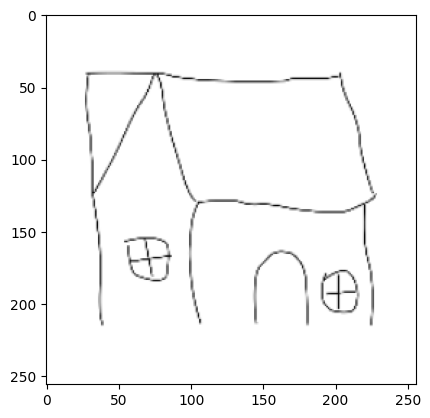

True label: dog, Predict label: elephant


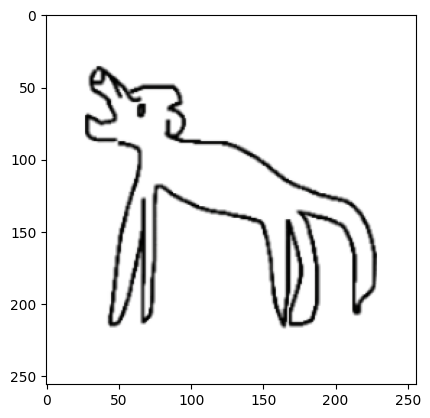

True label: elephant, Predict label: giraffe


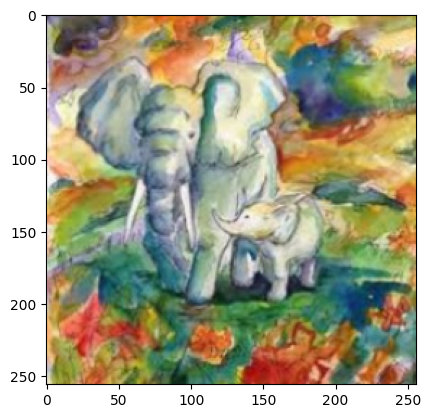

True label: horse, Predict label: house


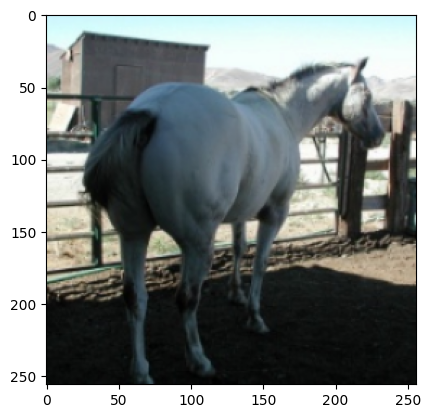

True label: horse, Predict label: dog


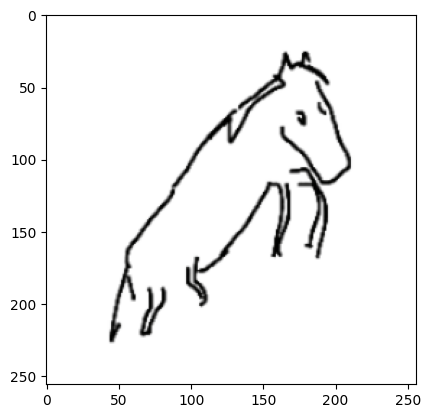

In [ ]:
model2, loss2 = part2_setup(LOAD_PATH = "/content/drive/MyDrive/classify.h5")
mislable(model2, test_ds, 5)

### Data Augmentation with Style Transfer

In [ ]:

def part2_transfer(model, dataset, content_idx, style_idx, alpha):

    # Tip: A large part of part1_inference can be applied here.
    content_dir_path = dataset.data_table.iloc[content_idx]['dir_path']
    content_filename = dataset.data_table.iloc[content_idx]['filename']
    content_dir_path = os.path.join(content_dir_path, content_filename)
    content_image = get_image(content_dir_path)
    content_image = preprocess(content_image)
    content_image = np.expand_dims(content_image, axis=0)

    style_dir_path = dataset.data_table.iloc[style_idx]['dir_path']
    style_filename = dataset.data_table.iloc[style_idx]['filename']
    style_dir_path = os.path.join(style_dir_path, style_filename)
    style_image = get_image(style_dir_path)
    style_image = preprocess(style_image)
    style_image = np.expand_dims(style_image, axis=0)

    alpha_tensor = tf.constant([alpha], dtype=tf.float32)

    output = model.predict([content_image, style_image, alpha_tensor])
    output_image = deprocess(output[0])
    output_image = tf.squeeze(output_image)
    img = array_to_img(output_image)

    # Instead of displaying the image, return it to be saved:
    return img

In [ ]:

def part2_augment(part1_load_path, dataset, output_tsv, output_dir, samples_per_pair = 50, alpha = 0.75, random_state = 4211):
    # We don't want to reload the model for every single sample,
    # so we load one here and pass it to the transfer function:
    model = load_model(part1_load_path, custom_objects={'AdaIN': AdaIN})

    # Get label and style samples to transfer from
    # These are expected to be in the form of
    # { "(label/style name)": [(list of indices in the dataset that corresponds to the label/style)], ... }
    # Tip: If you can have a pandas Dataframe from the dataset, you can use groupby(...).indices here.
    data_frame = dataset.data_table
    labeldict = data_frame.groupby('class_label').indices
    styledict = data_frame.groupby('style').indices

    # labeldict = {label: indices.tolist() for label, indices in label_samples.items()}
    # styledict = {style: indices.tolist() for style, indices in style_samples.items()}
    # print(dataset.data_table.head(10))
    # print(label_samples)



    # Generate random samples
    rng = np.random.default_rng(random_state)
    derived_tsv = "" # For usage in ClassificationDataset
    pair_set = set() # To prevent generating duplicates
    for label, label_idxs in labeldict.items():
        for style, style_idxs in styledict.items():
            for i in range(samples_per_pair):
                pair = None
                while not pair or pair in pair_set:
                    pair = rng.choice(label_idxs), rng.choice(style_idxs)
                pair_set.add(pair)

                # Generate 1 sample
                img = part2_transfer(model, dataset, pair[0], pair[1], alpha)

                # Make up a name for the same sample. Don't repeat the names!
                derived_name = f"{label}_{style}_{i}.jpg"
                # Add an entry to the TSV file. Follow the format of "train-data.tsv" and "test-data.tsv"!
                derived_entry = f"{derived_name}\t{style}\t{label}\n"

                # Save the image in the given folder
                img.save(os.path.join(output_dir, derived_name))
                # Add entry to the TSV to be written
                derived_tsv += derived_entry

    # Write the entries into the given file name
    with open(output_tsv, "w") as f:
        f.write(derived_tsv)


In [ ]:
PART1_MODEL_PATH = "/content/drive/MyDrive/saved.h5"
# os.path.join(data_path, 'saved.h5') # [Change to your part_1 saved weight]
ALPHA = 0.75

OUTPUT_TSV = "classify/derived-data.tsv"
OUTPUT_DIR = "classify/derived-files"

# Before running the augmentation, it is a good idea to prepare an empty directory for the generated outputs:
def part2_cleanup_augments(output_dir):
    !rm -rf "$output_dir"
    !mkdir -p "$output_dir"

In [ ]:
!cat "$OUTPUT_TSV"

cat: classify/derived-data.tsv: No such file or directory


In [ ]:
# Generate the dataset:
part2_cleanup_augments(OUTPUT_DIR)
part2_augment(PART1_MODEL_PATH, train_ds, OUTPUT_TSV, OUTPUT_DIR, samples_per_pair = 20, alpha = ALPHA, random_state = 4211)

1/1 [==============================] - 2s 2s/step


### Training the model with an augmented dataset

After generating the images we can produce a new, augmented dataset for retraining. We would like to add the data to the existing train dataset, in order to have a more balanced distribution between different styles and categories.

In [ ]:
def part2_prepare_aug_dataset():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 16
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    DERIVED_DS_PATH = os.path.join(pacs_path, "derived-files/")
    DERIVED_TSV_PATH = os.path.join(pacs_path, "derived-data.tsv")

    train2_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    train2_ds.add_data(DERIVED_TSV_PATH, DERIVED_DS_PATH)

    return train2_ds

train2_ds = part2_prepare_aug_dataset()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-37-87d4e20f80cf>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_table = s

In [ ]:
train2_ds.data_table

filename   style class_label  \
0             pic_2524.jpg  sketch         dog   
1              pic_888.jpg  sketch         dog   
2             pic_1279.jpg  sketch         dog   
3             pic_2694.jpg  sketch         dog   
4               pic_79.jpg  sketch         dog   
...                    ...     ...         ...   
2196  person_sketch_15.jpg  sketch      person   
2197  person_sketch_16.jpg  sketch      person   
2198  person_sketch_17.jpg  sketch      person   
2199  person_sketch_18.jpg  sketch      person   
2200  person_sketch_19.jpg  sketch      person   

                            one_hot_label                 dir_path  
0     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    classify/train-files/  
1     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    classify/train-files/  
2     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    classify/train-files/  
3     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    classify/train-files/  
4     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    classify/train-files/  
...                                   ...                      ...  
2196  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]  classify/derived-files/  
2197  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]  classify/derived-files/  
2198  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]  classify/derived-files/  
2199  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]  classify/derived-files/  
2200  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]  classify/derived-files/  

[2201 rows x 5 columns]

In [ ]:
is_unique = train2_ds.data_table['filename'].is_unique

if is_unique:
    print("The 'filename' column has unique values.")
else:
    print("The 'filename' column contains duplicate values.")

The 'filename' column has unique values.


We can confirm the augmentation by looking at its distribution:

In [ ]:
part2_tally_samples(train2_ds)

style         class_label
art_painting  dog             33
              elephant        33
              giraffe        251
              guitar          30
              horse          200
              house           31
              person          31
cartoon       dog             30
              elephant        33
              giraffe         32
              guitar         141
              horse           31
              house           32
              person          32
photo         dog             30
              elephant        33
              giraffe         32
              guitar          30
              horse           31
              house          235
              person         231
sketch        dog            249
              elephant       237
              giraffe         30
              guitar          29
              horse           28
              house           33
              person          33
dtype: int64

Now we can train another classifier using the augmented data:

In [ ]:
model3, loss3 = part2_setup()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, None, None, 64)    1792      
                                                                 
 conv1_2 (Conv2D)            (None, None, None, 64)    36928     
                                                                 
 pool1 (MaxPooling2D)        (None, None, None, 64)    0         
                                                                 
 conv2_1 (Conv2D)            (None, None, None, 128)   73856     
                                                                 
 conv2_2 (Conv2D)            (None, None, None, 128)   147584    
                                                                 
 pool2 (MaxPooling2D)        (None, None, None, 128)   0         
                                                                 
 conv3_1 (Conv2D)            (None, None, None, 256)  

In [ ]:
PART2_SAVE_PATH_2 = "/content/drive/MyDrive/classify-augmentation.h5" # [Change to your own path]

# [Call your train function here, training on train2_ds]
part2_train(model3, train2_ds, loss3, n_epochs=100, save_path=PART2_SAVE_PATH_2)

<ipython-input-28-f7dd8cf797b9>:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(dataset)/dataset.batch_size) # [Your code here]


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Test the model for any performance changes. After that, feel free to explore on more ways to improve the model!

In [ ]:
acc_test_aug, matrix_test_aug = part2_evaluate(model3, test_ds)

<ipython-input-60-d68ace3e562c>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_batches = np.math.ceil(len(dataset)/dataset.batch_size)


2/2 [==============================] - 0s 127ms/step


In [ ]:
print(acc_test_aug)
print(matrix_test_aug)

0.47601744186046513
[[178  35  82  23 113  30  31]
 [ 33 163  40   9  46  20  16]
 [106  25 195  22  19  28   5]
 [ 28   9  50 174  30  36  35]
 [117  41  14  25 140  27  13]
 [ 13  12  78   8  15 244   5]
 [ 44  17  58  27  34  23 216]]
